# 2D Acoustic Wave Equation
---

Consider the 2d acoustic wave equation
$$
\begin{aligned}
&\frac{\partial p}{\partial t} = -c^2(x, z)\rho(x, z)\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial z}\right) + f(x, z, t) \\
&\frac{\partial u}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial x} \\
&\frac{\partial v}{\partial t} = -\frac{1}{\rho(x, z)}\frac{\partial p}{\partial z},
\end{aligned}
$$
where $p$ is Pressure, $u, v$ are the $x, z-$components of Particle Velocity, $c, \rho$ are Medium Velocity and Density.

The RHS
$$
f(x, z, t) = R(t)\times 1_{\{x = x_s, z = z_s, t\}} 
$$
is the source term, represented by a Ricker wavelet
$$
R(t) = \left(1-2(\pi f_0(t-t_0))^2\right)\exp\left(-(\pi f_0(t-t_0))^2\right),
$$
where $f_0 = 50$ is the dominant frequency, $t_0 = 0.05$ is time delay.

<p style="color:red"> We can probably use the same technique as the numerical code, i.e., $f(x, z, t) = R(t)\times N(x, z)$, where $N(x, z)$ is a Gaussian centering at $(x_s, z = z_s)$ ? </p>

In this case,
$$
N(x, z) = \exp\left(-\frac{1}{\alpha^2}\left((x-x_s)^2+(z-z_s)^2\right)\right).
$$

---

## Scaling

Since the spatial and temporal domains differs in a large scale, we need to scale both domains to $[0, 1]$ before providing data directly into neural networks.

Let 
$$
x' = \frac{x}{x_0}, \ z' = \frac{z}{z_0}, \ t' = \frac{t}{t_0}, \ p' = \frac{p}{p_0}, \ u' = \frac{u}{u_0}, \ v' = \frac{v}{v_0}, \ c' = \frac{c}{c_0},
$$
where $x_0, z_0, t_0, p_0, u_0, v_0, c_0$ are scaling factors TBD.

Then the equations become
$$
\begin{aligned}
&\frac{p_0}{t_0}\frac{\partial p'}{\partial t'} = -c_0^2 c'^2(x_0x', z_0z')\rho(x_0x', z_0z')\left(\frac{u_0}{x_0}\frac{\partial u'}{\partial x'} + \frac{v_0}{z_0}\frac{\partial v'}{\partial z'}\right) + R(t_0 t')N(x_0x', z_0z', x_{0}x_s', z_{0}z_s') \\
&\frac{u_0}{t_0}\frac{\partial u'}{\partial t'} = -\frac{1}{\rho(x_0x', z_0z')}\frac{p_0}{x_0}\frac{\partial p'}{\partial x'} \\
&\frac{v_0}{t_0}\frac{\partial v'}{\partial t'} = -\frac{1}{\rho(x_0x', z_0z')}\frac{p_0}{z_0}\frac{\partial p'}{\partial z'}, 
\end{aligned}
$$

direct model: $(x', z', t', x_s') \to (p', u', v')$

inverse model: $(x', z') \to c$

Since $x, z \sim O(10^{2}),\ t\sim O(10^{-1}),\ p \sim O(10^{-3}),\ v \sim O(10^{-10})$, we can let
$$
x_0 = z_0 = 10^3, \ t_0 = 1, \ p_0 = u_0 = v_0 = 1, \ c_0 = 10^3,
$$

then the unit of $x, z$ are $km$, and the unit of $c$ is $km/s$.


---

## Possible scaling method

We can let $p' = \exp(p), u' = \exp(u), v' = \exp(v)$,
then
$$
\frac{\partial p}{\partial t} = \frac{1}{p'}\frac{\partial p'}{\partial t}, \cdots
$$

---

## Data

- $u$ is unknown
- $v_z$: Velocity in $z-$ direction; the $v$ variable in the equation
- $p$: Pressure
- $\rho(x, z)$: Medium density; We first assume it to be known as
$$
\rho(x, z) = \left\{
\begin{aligned}
&2000, &\quad z\in [100, 150], \\
&1000, &\quad \text{otherwise}.
\end{aligned}
\right.
$$

- All known data are collected in the spatial domain $(x, z) \in [1, 250]\times [1, 250]$, with grid size 5 (which means the spatial grids are {5, 10, ..., 250}. The temporal domain is $t\in [0, 0.25)$, with time step $dt = 0.0025$. This gives 100 time steps as recorded.

- The sources are located at $(x_s, z_s) = \{25, 50, \cdots, 225\} \times \{5\}$.

## Target
- Recover the direct problem $p, u, v$
- Recover the inverse problem $c$

In [1]:
NAME = "0627_1_direct_model_with_source_input_scale_equation_weighted_loss"

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("../../")
from Seismic_wave_inversion_PINN.tf_model_utils import *
from Seismic_wave_inversion_PINN.data_utils import *

plt.rcParams.update(plt.rcParamsDefault)
tf.keras.backend.set_floatx("float32")

%load_ext autoreload
%autoreload 2

In [31]:
def generate_model(layers, softplus = False, lambda_1 = 0):
	with tf.device("/device:gpu:0"):
# 		a = tf.Variable(np.ones((len(layers)-2, 1)), dtype = tf.float32)

# 		def atanh(a, x):
# 			return K.tanh(a*x)
		
# 		class ResNet(keras.Model): # 3-layer resnet
# 			def __init__(self, layers, softplus):
# 				super(ResNet, self).__init__()
# 				self._layers = []
# 				self.a = tf.Variable(np.ones((len(layers)-2, 1)), dtype = tf.float32)
# 				for i, l in enumerate(layers[:-2]):
# 					self._layers.append(keras.layers.Dense(layers[i+1], activation = lambda x: atanh(self.a[i], x)))
# 				if softplus:
# 					self._layers.append(keras.layers.Dense(layers[-1], activation = "softplus"))
# 				else:
# 					self._layers.append(keras.layers.Dense(layers[-1]))
			
# 			def call(self, inputs):
# 				x1 = self._layers[0](inputs)
# 				x2 = self._layers[1](x1)
# 				x2 = self._layers[2](x2)
# 				x2 += x1
# 				return self._layers[-1](x2)

		model = keras.models.Sequential()
		for i, l in enumerate(layers[:-2]):
# 			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = lambda x: atanh(a[i], x), kernel_regularizer = keras.regularizers.l1(lambda_1)))
# 			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = "relu", kernel_regularizer = keras.regularizers.l1(lambda_1)))
			model.add(keras.layers.Dense(layers[i+1], input_shape = (layers[i], ), activation = "elu", kernel_regularizer = keras.regularizers.l1(lambda_1)))
# 			model.add(keras.layers.BatchNormalization())
		if softplus:
			model.add(keras.layers.Dense(layers[-1], activation = "softplus", kernel_regularizer = keras.regularizers.l1(lambda_1)))
		else:
			model.add(keras.layers.Dense(layers[-1], kernel_regularizer = keras.regularizers.l1(lambda_1)))

# 		model.a = a
	return model
# 	return ResNet(layers, softplus)

n_models = 1
direct_layers = [4, 32, 32, 32, 32, 3] # (x, z, t, xs) -> (p, u, v)
lambda_1 = 0.5
direct_model = generate_model(direct_layers, False, lambda_1)

inverse_layers = [2, 32, 32, 1] # (x, z) -> (c)
inverse_model = generate_model(inverse_layers, softplus = True)

In [32]:
x0, z0, t0 = 1e3, 1e3, 1.0
p0, u0, v0 = 1.0, 1.0, 1.0
c0 = 1e3

In [33]:
@tf.function
def rho(x, z):
	return tf.where(tf.math.logical_and(tf.greater_equal(z, 100.0), tf.less_equal(z, 150.0)),
				   2000.0,
				   1000.0)

# source
f_0 = 50.0*np.pi
alpha = 2.0*5 # multiplied by dx
M0 = 1000 # scale p

@tf.function
def R(t, t_s):
	return M0*(1-2*(f_0*(t-t_s))**2)*tf.exp(-(f_0*(t-t_s))**2)

@tf.function
def N(x, z, x_s, z_s):
	return tf.exp(-1.0/(alpha**2) * ((x-x_s)**2 + (z-z_s)**2))

@tf.function
def f(x, z, t, x_s, z_s, t_s):
	return R(t, t_s)*N(x, z, x_s, z_s)

In [34]:
w_zero = 1e-2
threshold = 1e-3

def weighted_loss(true, pred):
	error = K.square(true - pred)
	error = K.mean(K.switch(K.less_equal(K.abs(true), threshold), w_zero * error , error))
	return error 

# @tf.function
# def weighted_loss(y_pred, y_true):
# # 	tf.print(tf.where(tf.less_equal(tf.abs(y_true), threshold),
# # 					w_zero*tf.abs(y_pred - y_true),
# # 					w_nonzero*tf.abs(y_pred - y_true)))
# 	return tf.reduce_mean(tf.where(tf.less_equal(tf.abs(y_true), threshold),
# 					w_zero*tf.abs(y_pred - y_true),
# 					w_nonzero*tf.abs(y_pred - y_true)))

In [35]:
loss_func = keras.losses.MeanSquaredError()
loss_func_r = keras.losses.MeanAbsoluteError() # l1 loss

def get_residue_loss(tape, p, u, v, c, x, z, t, x_s, z_s, t_s):
	dp_dt = tape.gradient(p, t)
	dp_dx = tape.gradient(p, x)
	dp_dz = tape.gradient(p, z)
	du_dt = tape.gradient(u, t)
	du_dx = tape.gradient(u, x)
	dv_dt = tape.gradient(v, t)
	dv_dz = tape.gradient(v, z)
	eq1 = loss_func_r(p0/t0*dp_dt, -c0**2*tf.square(c)*rho(x0*x, z0*z)*(u0/x0*du_dx+v0/z0*dv_dz)+f(x0*x, z0*z, t0*t, x0*x_s, z0*z_s, t0*t_s))
	eq2 = loss_func_r(u0/t0*du_dt, -1.0/rho(x0*x, z0*z)*p0/x0*dp_dx)
	eq3 = loss_func_r(v0/t0*dv_dt, -1.0/rho(x0*x, z0*z)*p0/z0*dp_dz)
	return eq1, eq2, eq3
	
def step(data_sources):
	losses = []
	with tf.GradientTape(persistent = True) as tape:
		tape.watch([x for d in data_sources for x in d])
		for data in data_sources:
			[x_c, z_c, t_c, x_s_c, z_s_c, t_s_c,
			 x_i, z_i, t_i, p_i, u_i, v_i, x_s_i, z_s_i, t_s_i,
			 x_d, z_d, t_d, p_d, v_d, x_s_d, z_s_d, t_s_d] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c1, loss_c2, loss_c3 = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s_c, z_s_c, t_s_c)
			loss_dr1, loss_dr2, loss_dr3 = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s_d, z_s_d, t_s_d)
			loss_dv = weighted_loss(out_d[:, 0:1], p_d) # + loss_func(out_d[:, 2:3], v_d)
			loss_ir1, loss_ir2, loss_ir3 = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s_i, z_s_i, t_s_i)
			loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			losses.append([loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv])

		loss_c1 = sum([l[0] for l in losses])
		loss_c2 = sum([l[1] for l in losses])
		loss_c3 = sum([l[2] for l in losses])
		loss_dr1 = sum([l[3] for l in losses])
		loss_dr2 = sum([l[4] for l in losses])
		loss_dr3 = sum([l[5] for l in losses])
		loss_dv = sum([l[6] for l in losses])
		loss_ir1 = sum([l[7] for l in losses])
		loss_ir2 = sum([l[8] for l in losses])
		loss_ir3 = sum([l[9] for l in losses])
		loss_iv = sum([l[10] for l in losses])
		
		loss = w_c1*loss_c1 + w_c2*loss_c2 + w_c3*loss_c3 + w_dr1*loss_dr1 + w_dr2*loss_dr2 + w_dr3*loss_dr3 + \
				w_dv*loss_dv + w_ir1*loss_ir1 + w_ir2*loss_ir2 + w_ir3*loss_ir3 + w_iv*loss_iv
		
	grads = tape.gradient(loss, direct_model.trainable_variables + inverse_model.trainable_variables )#+ [direct_model.a] + [inverse_model.a])
# 	tf.print(grads)
	optimizer.apply_gradients(zip(grads, direct_model.trainable_variables + inverse_model.trainable_variables))# + [direct_model.a] + [inverse_model.a]))
	
	del tape
	return loss, loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv


def train(data_sources, epochs, batch_proportion = 0.1, print_every = 100, save_every = 10000, save_path = None):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
# 	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
#                                         for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s])
	for epoch in range(1, epochs+1):
		losses = np.zeros((12,))
		for d in zip(*data_s): # d: [d_1_c, d_1_i, d_1_d, d_2_c, ...]
			data_sources = [list(d[i*3])+list(d[i*3+1])+list(d[i*3+2]) for i in range(n_sources)]
			loss = step(data_sources)
			losses += np.array(loss)
		losses *= batch_proportion
		
		if epoch % print_every == 0:
			print("{}, Epoch: {}, Loss: {:.4e}, c1: {:.4e}, c2: {:.4e}, c3: {:.4e}, dr1: {:.4e}, dr2: {:.4e}, dr3: {:.4e}, \
					  dv: {:.4e}, ir1: {:.4e}, ir2: {:.4e}, ir3: {:.4e}, iv: {:.4e}".format(get_time(), epoch, *list(losses)))

		if epoch % save_every == 0:
			direct_model.save("models/{}/{}/direct_model".format(NAME, save_path))
			inverse_model.save("models/{}/{}/inverse_model".format(NAME, save_path))
			
class LBFGS(LBFGS_compatible):
	def set_data(self, data_sources):
		self.data_sources = data_sources
	
	@tf.function
	def loss_function(self, tape):
		tape.watch([x for d in self.data_sources for x in d])
		losses = []
		for data in self.data_sources:
			[x_c, z_c, t_c, x_s_c, z_s_c, t_s_c,
			 x_i, z_i, t_i, p_i, u_i, v_i, x_s_i, z_s_i, t_s_i,
			 x_d, z_d, t_d, p_d, v_d, x_s_d, z_s_d, t_s_d] = data
			out_c = direct_model(tf.concat([x_c, z_c, t_c, x_s_c], axis = 1))
			c_c = inverse_model(tf.concat([x_c, z_c], axis = 1))
			out_d = direct_model(tf.concat([x_d, z_d, t_d, x_s_d], axis = 1))
			c_d = inverse_model(tf.concat([x_d, z_d], axis = 1))
			out_i = direct_model(tf.concat([x_i, z_i, t_i, x_s_i], axis = 1))
			c_i = inverse_model(tf.concat([x_i, z_i], axis = 1))
			loss_c1, loss_c2, loss_c3 = get_residue_loss(tape, out_c[:, 0:1], out_c[:, 1:2], out_c[:, 2:3], c_c, x_c, z_c, t_c, x_s_c, z_s_c, t_s_c)
			loss_dr1, loss_dr2, loss_dr3 = get_residue_loss(tape, out_d[:, 0:1], out_d[:, 1:2], out_d[:, 2:3], c_d, x_d, z_d, t_d, x_s_d, z_s_d, t_s_d)
			loss_dv = weighted_loss(out_d[:, 0:1], p_d) # + loss_func(out_d[:, 2:3], v_d)
			loss_ir1, loss_ir2, loss_ir3 = get_residue_loss(tape, out_i[:, 0:1], out_i[:, 1:2], out_i[:, 2:3], c_i, x_i, z_i, t_i, x_s_i, z_s_i, t_s_i)
			loss_iv = loss_func(out_i[:, 0:1], p_i) + loss_func(out_i[:, 1:2], u_i) + loss_func(out_i[:, 2:3], v_i)
			losses.append([loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv])

		loss_c1 = sum([l[0] for l in losses])
		loss_c2 = sum([l[1] for l in losses])
		loss_c3 = sum([l[2] for l in losses])
		loss_dr1 = sum([l[3] for l in losses])
		loss_dr2 = sum([l[4] for l in losses])
		loss_dr3 = sum([l[5] for l in losses])
		loss_dv = sum([l[6] for l in losses])
		loss_ir1 = sum([l[7] for l in losses])
		loss_ir2 = sum([l[8] for l in losses])
		loss_ir3 = sum([l[9] for l in losses])
		loss_iv = sum([l[10] for l in losses])
		
		loss = w_c1*loss_c1 + w_c2*loss_c2 + w_c3*loss_c3 + w_dr1*loss_dr1 + w_dr2*loss_dr2 + w_dr3*loss_dr3 + \
				w_dv*loss_dv + w_ir1*loss_ir1 + w_ir2*loss_ir2 + w_ir3*loss_ir3 + w_iv*loss_iv
		return loss, loss_c1, loss_c2, loss_c3, loss_dr1, loss_dr2, loss_dr3, loss_dv, loss_ir1, loss_ir2, loss_ir3, loss_iv
	
def LBFGS_batch_optimize(data_sources, batch_proportion = 0.01, save_path = "", model_names = None, loss_names = None, print_every = 1, **kwargs):
	shuffled = lambda dataset: [tf.data.Dataset.from_tensor_slices(tuple(d)).shuffle(buffer_size = max(d[0].shape[0], 1), \
                                                        reshuffle_each_iteration = True).batch(max(int(batch_proportion*d[0].shape[0]), 1)) \
                                        for d in dataset]
	data_s = shuffled([d for d_s in data_sources for d in d_s])
	for d in zip(*data_s): # d: [d_1_c, d_1_i, d_1_d, d_2_c, ...]
		data_sources = [list(d[i*3])+list(d[i*3+1])+list(d[i*3+2]) for i in range(n_sources)]
		LBFGS_optimizer = LBFGS([direct_model, inverse_model])
		LBFGS_optimizer.set_data(data_sources)
		LBFGS_optimizer.optimize(save_path = "models/{}/{}/".format(NAME, save_path), model_names = model_names, loss_names = loss_names, print_loss = True, **kwargs)
	del LBFGS_optimizer

In [36]:
from scipy.io import loadmat

x_s = np.linspace(25.0, 225.0, 9) / x0
z_s = 5.0 / z0
t_s = 0.05 / t0
n_sources = len(x_s)

domain = [0, 250]
T_max = 0.25
dx = 5
dt = 0.0025

x_d = np.linspace(5.0, 250.0, 50) / x0
z_d = np.array([5.0]) / z0
t_d = np.linspace(0.0, 0.2475, 100) / t0

n_c = 1000
x_c = transform(np.random.random((n_c, 1)), *domain) / x0
z_c = transform(np.random.random((n_c, 1)), *domain) / z0
t_c = transform(np.random.random((n_c, 1)), 0, T_max) / t0

n_s = 100
x_c_source = np.vstack([transform(np.random.random((n_s, 1)), xi-5, xi+5) for xi in x_s]) / x0
z_c_source = np.vstack([transform(np.random.random((n_s, 1)), z_s-5, z_s+5) for i in x_s]) / z0
t_c_source = np.vstack([transform(np.random.random((n_s, 1)), t_s-0.05, t_s+0.05) for i in x_s]) / t0

x_c = np.vstack([x_c, x_c_source]) / x0
z_c = np.vstack([z_c, z_c_source]) / z0
t_c = np.vstack([t_c, t_c_source]) / t0

n_i = 2000
x_i = transform(np.random.random((n_i, 1)), *domain) / x0
z_i = transform(np.random.random((n_i, 1)), *domain) / z0
t_i = np.zeros_like(x_i) / t0
p_i = np.zeros_like(x_i) / p0
u_i = np.zeros_like(x_i) / u0
v_i = np.zeros_like(x_i) / v0

# txz_c = tensor_grid([t_c, x_c, z_c])
txz_d = tensor_grid([t_d, x_d, z_d])

map_to_tf_float32 = lambda x: list(map(lambda y: tf.constant(y, dtype = tf.float32), x))

data_sources = []
for x in x_s:
	p = loadmat("data/sr_p_{}.mat".format(int(x*x0/5)))["sr"].reshape((-1, 1)) / p0 * 1000
	v = loadmat("data/sr_vz_{}.mat".format(int(x*x0/5)))["sr"].reshape((-1, 1)) / v0
	d_i = map_to_tf_float32([x_i, z_i, t_i, p_i, u_i, v_i, x*np.ones_like(x_i), z_s*np.ones_like(z_i), t_s*np.ones_like(t_i)])
	d_c = map_to_tf_float32([x_c, z_c, t_c, x*np.ones_like(x_c), z_s*np.ones_like(z_c), t_s*np.ones_like(t_c)])
	d_d = map_to_tf_float32([txz_d[:, 1:2], txz_d[:, 2:3], txz_d[:, 0:1], p, v, x*np.ones_like(txz_d[:, 1:2]), z_s*np.ones_like(txz_d[:, 2:3]), t_s*np.ones_like(txz_d[:, 0:1])])
	data_sources.append([d_c, d_i, d_d])

In [37]:
i = 1
optimizer = keras.optimizers.Adam(lr = 1e-2)

w_c1, w_c2, w_c3 = [0]*3
w_dr1, w_dr2, w_dr3 = [0]*3
w_ir1, w_ir2, w_ir3 = [0]*3
w_dv = 1.0
w_iv = 0.0

w_zero = 0.1
threshold = 1e-4

train(data_sources, 200, batch_proportion = 1.0, print_every = 1, save_every = 100, save_path = "{}_adam".format(i))

2020/06/29, 19:59:47, Epoch: 1, Loss: 4.7806e-02, c1: 2.6342e+06, c2: 1.7463e+00, c3: 3.4587e+00, dr1: 2.4657e+06, dr2: 1.7105e+00, dr3: 3.4569e+00, 					  dv: 4.7806e-02, ir1: 3.2883e+06, ir2: 1.7706e+00, ir3: 3.5700e+00, iv: 3.2442e-02
2020/06/29, 19:59:51, Epoch: 2, Loss: 1.2426e+00, c1: 2.7655e+06, c2: 1.2880e+00, c3: 2.9590e+00, dr1: 2.5508e+06, dr2: 1.2742e+00, dr3: 2.9380e+00, 					  dv: 1.2426e+00, ir1: 3.3030e+06, ir2: 1.3021e+00, ir3: 2.9649e+00, iv: 7.8508e-01
2020/06/29, 19:59:59, Epoch: 3, Loss: 1.0995e-01, c1: 2.8769e+06, c2: 1.4914e+00, c3: 3.3588e+00, dr1: 2.6468e+06, dr2: 1.4658e+00, dr3: 3.3416e+00, 					  dv: 1.0995e-01, ir1: 3.4462e+06, ir2: 1.5247e+00, ir3: 3.3598e+00, iv: 5.1299e-02
2020/06/29, 20:00:03, Epoch: 4, Loss: 1.1267e-01, c1: 2.9494e+06, c2: 1.4814e+00, c3: 3.5627e+00, dr1: 2.6952e+06, dr2: 1.4636e+00, dr3: 3.5230e+00, 					  dv: 1.1267e-01, ir1: 3.5536e+06, ir2: 1.5182e+00, ir3: 3.5931e+00, iv: 1.0230e-01
2020/06/29, 20:00:06, Epoch: 5, Loss: 1.9014e-01

2020/06/29, 20:01:10, Epoch: 24, Loss: 5.8256e-02, c1: 2.0347e+06, c2: 1.2859e+00, c3: 1.9542e+00, dr1: 1.8782e+06, dr2: 1.2767e+00, dr3: 1.9651e+00, 					  dv: 5.8256e-02, ir1: 2.2913e+06, ir2: 1.4234e+00, ir3: 1.8514e+00, iv: 1.3860e-01
2020/06/29, 20:01:13, Epoch: 25, Loss: 5.5849e-02, c1: 1.9691e+06, c2: 1.2953e+00, c3: 1.9606e+00, dr1: 1.8168e+06, dr2: 1.2863e+00, dr3: 1.9714e+00, 					  dv: 5.5849e-02, ir1: 2.2128e+06, ir2: 1.4358e+00, ir3: 1.8586e+00, iv: 1.3168e-01
2020/06/29, 20:01:17, Epoch: 26, Loss: 5.0012e-02, c1: 1.9181e+06, c2: 1.2861e+00, c3: 1.9613e+00, dr1: 1.7681e+06, dr2: 1.2760e+00, dr3: 1.9716e+00, 					  dv: 5.0012e-02, ir1: 2.1484e+06, ir2: 1.4295e+00, ir3: 1.8577e+00, iv: 1.2438e-01
2020/06/29, 20:01:20, Epoch: 27, Loss: 4.5510e-02, c1: 1.8756e+06, c2: 1.2662e+00, c3: 1.9579e+00, dr1: 1.7270e+06, dr2: 1.2544e+00, dr3: 1.9680e+00, 					  dv: 4.5510e-02, ir1: 2.0924e+06, ir2: 1.4125e+00, ir3: 1.8522e+00, iv: 1.2083e-01
2020/06/29, 20:01:24, Epoch: 28, Loss: 4.529

2020/06/29, 20:03:08, Epoch: 59, Loss: 4.4817e-02, c1: 1.3552e+06, c2: 1.4254e+00, c3: 2.2930e+00, dr1: 1.2542e+06, dr2: 1.4126e+00, dr3: 2.3174e+00, 					  dv: 4.4817e-02, ir1: 1.5202e+06, ir2: 1.5701e+00, ir3: 2.2161e+00, iv: 7.3826e-02
2020/06/29, 20:03:11, Epoch: 60, Loss: 4.4669e-02, c1: 1.3581e+06, c2: 1.4294e+00, c3: 2.2950e+00, dr1: 1.2572e+06, dr2: 1.4165e+00, dr3: 2.3198e+00, 					  dv: 4.4669e-02, ir1: 1.5248e+06, ir2: 1.5730e+00, ir3: 2.2194e+00, iv: 7.2519e-02
2020/06/29, 20:03:15, Epoch: 61, Loss: 3.7975e-02, c1: 1.3616e+06, c2: 1.4335e+00, c3: 2.2972e+00, dr1: 1.2606e+06, dr2: 1.4207e+00, dr3: 2.3224e+00, 					  dv: 3.7975e-02, ir1: 1.5300e+06, ir2: 1.5759e+00, ir3: 2.2230e+00, iv: 7.1208e-02
2020/06/29, 20:03:18, Epoch: 62, Loss: 4.4669e-02, c1: 1.3648e+06, c2: 1.4373e+00, c3: 2.2990e+00, dr1: 1.2638e+06, dr2: 1.4245e+00, dr3: 2.3245e+00, 					  dv: 4.4669e-02, ir1: 1.5348e+06, ir2: 1.5786e+00, ir3: 2.2260e+00, iv: 7.0169e-02
2020/06/29, 20:03:22, Epoch: 63, Loss: 4.475

2020/06/29, 20:05:04, Epoch: 94, Loss: 4.4217e-02, c1: 1.3594e+06, c2: 1.4429e+00, c3: 2.2897e+00, dr1: 1.2604e+06, dr2: 1.4312e+00, dr3: 2.3164e+00, 					  dv: 4.4217e-02, ir1: 1.5337e+06, ir2: 1.5875e+00, ir3: 2.2197e+00, iv: 7.0764e-02
2020/06/29, 20:05:07, Epoch: 95, Loss: 4.4435e-02, c1: 1.3588e+06, c2: 1.4423e+00, c3: 2.2893e+00, dr1: 1.2599e+06, dr2: 1.4306e+00, dr3: 2.3160e+00, 					  dv: 4.4435e-02, ir1: 1.5330e+06, ir2: 1.5870e+00, ir3: 2.2192e+00, iv: 7.0861e-02
2020/06/29, 20:05:11, Epoch: 96, Loss: 4.4458e-02, c1: 1.3587e+06, c2: 1.4418e+00, c3: 2.2891e+00, dr1: 1.2598e+06, dr2: 1.4301e+00, dr3: 2.3158e+00, 					  dv: 4.4458e-02, ir1: 1.5329e+06, ir2: 1.5866e+00, ir3: 2.2189e+00, iv: 7.0872e-02
2020/06/29, 20:05:14, Epoch: 97, Loss: 4.4329e-02, c1: 1.3590e+06, c2: 1.4415e+00, c3: 2.2891e+00, dr1: 1.2601e+06, dr2: 1.4298e+00, dr3: 2.3157e+00, 					  dv: 4.4329e-02, ir1: 1.5333e+06, ir2: 1.5862e+00, ir3: 2.2189e+00, iv: 7.0798e-02
2020/06/29, 20:05:18, Epoch: 98, Loss: 4.402

2020/06/29, 20:07:01, Epoch: 128, Loss: 3.8014e-02, c1: 1.3624e+06, c2: 1.4388e+00, c3: 2.2798e+00, dr1: 1.2636e+06, dr2: 1.4272e+00, dr3: 2.3061e+00, 					  dv: 3.8014e-02, ir1: 1.5383e+06, ir2: 1.5835e+00, ir3: 2.2099e+00, iv: 7.0461e-02
2020/06/29, 20:07:04, Epoch: 129, Loss: 3.9295e-02, c1: 1.3621e+06, c2: 1.4382e+00, c3: 2.2797e+00, dr1: 1.2634e+06, dr2: 1.4266e+00, dr3: 2.3059e+00, 					  dv: 3.9295e-02, ir1: 1.5380e+06, ir2: 1.5829e+00, ir3: 2.2097e+00, iv: 7.0477e-02
2020/06/29, 20:07:08, Epoch: 130, Loss: 4.2026e-02, c1: 1.3618e+06, c2: 1.4375e+00, c3: 2.2795e+00, dr1: 1.2631e+06, dr2: 1.4258e+00, dr3: 2.3058e+00, 					  dv: 4.2026e-02, ir1: 1.5376e+06, ir2: 1.5821e+00, ir3: 2.2094e+00, iv: 7.0481e-02
2020/06/29, 20:07:11, Epoch: 131, Loss: 4.2057e-02, c1: 1.3617e+06, c2: 1.4369e+00, c3: 2.2794e+00, dr1: 1.2630e+06, dr2: 1.4252e+00, dr3: 2.3056e+00, 					  dv: 4.2057e-02, ir1: 1.5375e+06, ir2: 1.5815e+00, ir3: 2.2092e+00, iv: 7.0454e-02
2020/06/29, 20:07:14, Epoch: 132, Loss: 

2020/06/29, 20:09:00, Epoch: 163, Loss: 3.8382e-02, c1: 1.3592e+06, c2: 1.4325e+00, c3: 2.2651e+00, dr1: 1.2608e+06, dr2: 1.4208e+00, dr3: 2.2907e+00, 					  dv: 3.8382e-02, ir1: 1.5357e+06, ir2: 1.5776e+00, ir3: 2.1955e+00, iv: 6.9591e-02
2020/06/29, 20:09:04, Epoch: 164, Loss: 3.5312e-02, c1: 1.3592e+06, c2: 1.4324e+00, c3: 2.2646e+00, dr1: 1.2608e+06, dr2: 1.4207e+00, dr3: 2.2902e+00, 					  dv: 3.5312e-02, ir1: 1.5358e+06, ir2: 1.5774e+00, ir3: 2.1951e+00, iv: 6.9544e-02
2020/06/29, 20:09:07, Epoch: 165, Loss: 4.0927e-02, c1: 1.3588e+06, c2: 1.4318e+00, c3: 2.2641e+00, dr1: 1.2604e+06, dr2: 1.4201e+00, dr3: 2.2896e+00, 					  dv: 4.0927e-02, ir1: 1.5353e+06, ir2: 1.5769e+00, ir3: 2.1945e+00, iv: 6.9523e-02
2020/06/29, 20:09:11, Epoch: 166, Loss: 3.8063e-02, c1: 1.3588e+06, c2: 1.4317e+00, c3: 2.2636e+00, dr1: 1.2604e+06, dr2: 1.4200e+00, dr3: 2.2891e+00, 					  dv: 3.8063e-02, ir1: 1.5354e+06, ir2: 1.5768e+00, ir3: 2.1940e+00, iv: 6.9479e-02
2020/06/29, 20:09:14, Epoch: 167, Loss: 

2020/06/29, 20:11:02, Epoch: 198, Loss: 4.4027e-02, c1: 1.3602e+06, c2: 1.4203e+00, c3: 2.2469e+00, dr1: 1.2623e+06, dr2: 1.4084e+00, dr3: 2.2718e+00, 					  dv: 4.4027e-02, ir1: 1.5380e+06, ir2: 1.5655e+00, ir3: 2.1770e+00, iv: 6.9120e-02
2020/06/29, 20:11:05, Epoch: 199, Loss: 4.3997e-02, c1: 1.3604e+06, c2: 1.4196e+00, c3: 2.2466e+00, dr1: 1.2625e+06, dr2: 1.4078e+00, dr3: 2.2716e+00, 					  dv: 4.3997e-02, ir1: 1.5382e+06, ir2: 1.5648e+00, ir3: 2.1767e+00, iv: 6.9104e-02
2020/06/29, 20:11:09, Epoch: 200, Loss: 4.3720e-02, c1: 1.3608e+06, c2: 1.4192e+00, c3: 2.2464e+00, dr1: 1.2629e+06, dr2: 1.4073e+00, dr3: 2.2714e+00, 					  dv: 4.3720e-02, ir1: 1.5388e+06, ir2: 1.5642e+00, ir3: 2.1765e+00, iv: 6.9047e-02
INFO:tensorflow:Assets written to: models/0627_1_direct_model_with_source_input_scale_equation_weighted_loss/1_adam/direct_model/assets
INFO:tensorflow:Assets written to: models/0627_1_direct_model_with_source_input_scale_equation_weighted_loss/1_adam/inverse_model/assets


In [40]:
i = 1
w_c1, w_c2, w_c3 = [0]*3
w_dr1, w_dr2, w_dr3 = [0]*3
w_ir1, w_ir2, w_ir3 = [0]*3
w_dv = 1.0
w_iv = 0.0

w_zero = 0.1
threshold = 1e-4

LBFGS_batch_optimize(data_sources, batch_proportion = 1.0, save_path = "{}_lbfgs".format(i), 
					model_names = ["direct_model", "inverse_model"],
					loss_names = ["c1", "c2", "c3", "dr1", "dr2", "dr3", "dv", "ir1", "ir2", "ir3", "iv"],
					 num_correction_pairs=200,
					 tolerance=1e-31, 
					 x_tolerance=1e-31, 
					 f_relative_tolerance=1e-31,
					 initial_inverse_hessian_estimate=None, 
					 max_iterations=10000)

Convergence: 0
INFO:tensorflow:Assets written to: models/models/0627_1_direct_model_with_source_input_scale_equation_weighted_loss/1_lbfgs//direct_model/assets
INFO:tensorflow:Assets written to: models/models/0627_1_direct_model_with_source_input_scale_equation_weighted_loss/1_lbfgs//inverse_model/assets
2020/06/29, 20:23:36, Iter: 38, Loss: 3.8432e-02, c1: 1.3614e+06, c2: 1.4188e+00, c3: 2.2463e+00, dr1: 1.2635e+06, dr2: 1.4069e+00, dr3: 2.2712e+00, dv: 3.8432e-02, ir1: 1.5395e+06, ir2: 1.5637e+00, ir3: 2.1764e+00, iv: 6.8975e-02,  


In [43]:
i = 1
optimizer.learning_rate = 1e-2

w_c1, w_c2, w_c3 = [0]*3
w_dr1, w_dr2, w_dr3 = [0]*3
w_ir1, w_ir2, w_ir3 = [0]*3
w_dv = 1.0
w_iv = 1e-2

w_zero = 0.1
threshold = 1e-4

train(data_sources, 200, batch_proportion = 1.0, print_every = 10, save_every = 100, save_path = "{}_adam".format(i))

2020/06/29, 20:41:18, Epoch: 10, Loss: 4.4569e-02, c1: 1.3252e+05, c2: 2.6349e+00, c3: 1.7786e+00, dr1: 1.2998e+05, dr2: 2.6505e+00, dr3: 1.8228e+00, 					  dv: 4.4451e-02, ir1: 1.2785e+05, ir2: 2.7834e+00, ir3: 1.7269e+00, iv: 1.1772e-02
2020/06/29, 20:41:50, Epoch: 20, Loss: 3.0208e-02, c1: 3.0783e+05, c2: 2.4699e+00, c3: 1.2917e+00, dr1: 2.9763e+05, dr2: 2.4804e+00, dr3: 1.3482e+00, 					  dv: 3.0145e-02, ir1: 3.4514e+05, ir2: 2.6201e+00, ir3: 1.2597e+00, iv: 6.3014e-03
2020/06/29, 20:42:24, Epoch: 30, Loss: 4.4535e-02, c1: 2.0587e+05, c2: 2.1610e+00, c3: 8.2628e-01, dr1: 2.0269e+05, dr2: 2.1623e+00, dr3: 8.8222e-01, 					  dv: 4.4515e-02, ir1: 2.3168e+05, ir2: 2.2959e+00, ir3: 8.0957e-01, iv: 2.0664e-03
2020/06/29, 20:42:55, Epoch: 40, Loss: 3.1049e-02, c1: 1.6362e+05, c2: 2.2676e+00, c3: 6.4053e-01, dr1: 1.4124e+05, dr2: 2.2722e+00, dr3: 6.9774e-01, 					  dv: 3.1048e-02, ir1: 1.9672e+05, ir2: 2.4035e+00, ir3: 6.3147e-01, iv: 1.7604e-04
2020/06/29, 20:43:27, Epoch: 50, Loss: 4.445

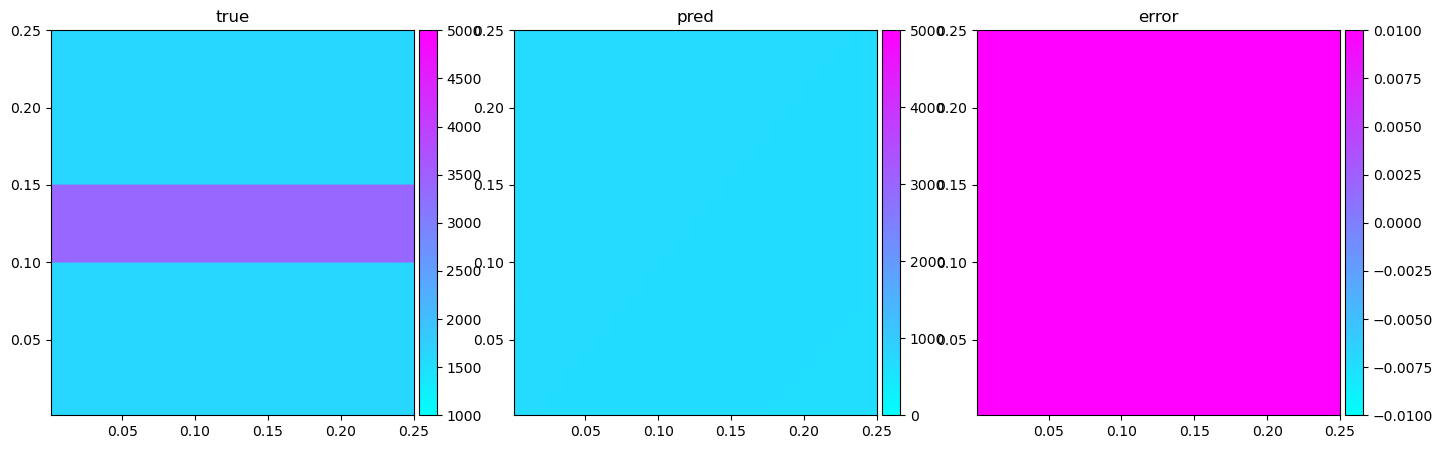

In [44]:
x_test = np.linspace(1.0, 250.0, 250) / x0
z_test = np.linspace(1.0, 250.0, 499) / z0
xz_test = tensor_grid([z_test, x_test])
xz_test[:, [0, 1]] = xz_test[:, [1, 0]]

c_pred = inverse_model(tf.constant(xz_test, dtype = tf.float32))*c0
def c_func(x, z):
	return np.piecewise(z, [z > 150, (z >= 100) & (z <= 150), z < 100], [1500, 3500, 1500])
c_true = c_func(xz_test[:, 0:1]*x0, xz_test[:, 1:2]*z0)

import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cool
norm = Normalize(vmin=1000, vmax=5000)

X, Z = np.meshgrid(x_test, z_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, Z, c_true.reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[0].set_title("true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=0, vmax=5000)
im1 = ax[1].contourf(X, Z, c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[1].set_title("pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, Z, c_true.reshape((len(z_test), len(x_test)))-c_pred.numpy().reshape((len(z_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()

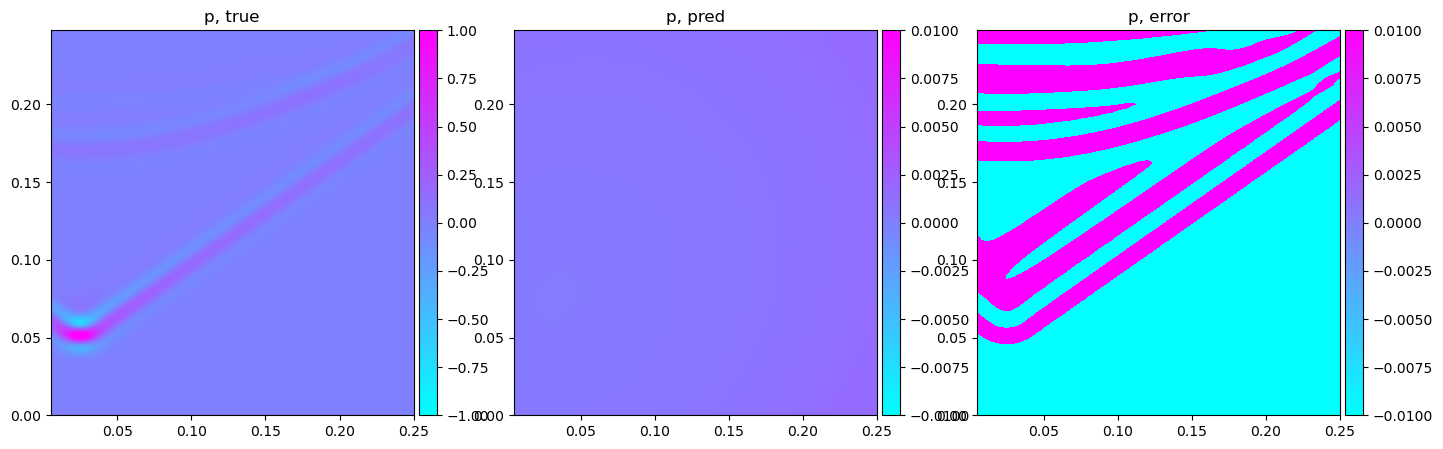

In [45]:
i = 0
p = loadmat("data/sr_p_{}.mat".format(int(x_s[i]*x0/5)))["sr"]*1000
v = loadmat("data/sr_vz_{}.mat".format(int(x_s[i]*x0/5)))["sr"]

x_test = np.linspace(5.0, 250.0, 50) / x0
# z_test = np.linspace(1.0, 250.0, 250)
z_test = np.array([5]) / z0
t_test = np.linspace(0.0, 0.2475, 100) / t0
xzt_test = tensor_grid([t_test, x_test, z_test])
xzt_test[:, [0, 1, 2]] = xzt_test[:, [1, 2, 0]]

xzts = np.hstack([xzt_test, x_s[i]*np.ones_like(xzt_test[:, 0:1])])
out = direct_model(tf.constant(xzts, dtype = tf.float32))

cmap = cool
norm = Normalize(vmin=-1, vmax=1)

X, T = np.meshgrid(x_test, t_test)
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
fig.subplots_adjust(right = 1.0)

im0 = ax[0].contourf(X, T, p, cmap = cmap, norm = norm, levels = 1000)
ax[0].set_title("p, true")
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = Normalize(vmin=-0.01, vmax=0.01)
im1 = ax[1].contourf(X, T, out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm, levels = 1000)
ax[1].set_title("p, pred")
ax[1].set_xlabel("")
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

norm = mpl.colors.Normalize(vmin=-1e-2, vmax=1e-2)
im2 = ax[2].contourf(X, T, p-out[:, 0:1].numpy().reshape((len(t_test), len(x_test))), cmap = cmap, norm = norm)
ax[2].set_title("p, error")
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

plt.show()